<ipython-input-11-7d5b7e43b078>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))
<ipython-input-11-7d5b7e43b078>:69: 

Models loaded successfully!
Do you wish to train(1: yes, 2: no)
Enter reply1
Epoch [0/50] Batch 0/469 | D Loss: 0.7810 | G Loss: 2.3134
Epoch [0/50] Batch 100/469 | D Loss: 1.0410 | G Loss: 2.6033
Epoch [0/50] Batch 200/469 | D Loss: 0.8506 | G Loss: 1.3115
Epoch [0/50] Batch 300/469 | D Loss: 0.7624 | G Loss: 1.7670
Epoch [0/50] Batch 400/469 | D Loss: 0.7886 | G Loss: 1.6477
Epoch [1/50] Batch 0/469 | D Loss: 0.8801 | G Loss: 1.8896
Epoch [1/50] Batch 100/469 | D Loss: 0.9689 | G Loss: 1.8555
Epoch [1/50] Batch 200/469 | D Loss: 1.1288 | G Loss: 1.9576
Epoch [1/50] Batch 300/469 | D Loss: 0.9095 | G Loss: 1.4948
Epoch [1/50] Batch 400/469 | D Loss: 0.9504 | G Loss: 2.1143
Epoch [2/50] Batch 0/469 | D Loss: 1.0192 | G Loss: 1.5002
Epoch [2/50] Batch 100/469 | D Loss: 0.9171 | G Loss: 1.2177
Epoch [2/50] Batch 200/469 | D Loss: 0.7967 | G Loss: 1.9174
Epoch [2/50] Batch 300/469 | D Loss: 1.0326 | G Loss: 1.2438
Epoch [2/50] Batch 400/469 | D Loss: 0.9174 | G Loss: 1.2885
Epoch [3/50] B

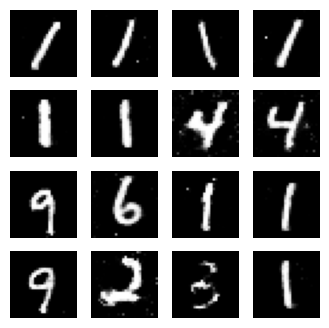

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Check if GPU is available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size=128
lr=0.0002
epochs=50
latent_dim=100
image_size=28 * 28

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset=torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True)
#generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1,1,28,28)

#discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

# # Initialize models and move to GPU
# generator=Generator().to(device)
# discriminator=Discriminator().to(device)

generator =Generator().to(device)
discriminator=Discriminator().to(device)

# Load the saved weights
generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

generator.eval()
discriminator.eval()

print("Models loaded successfully!")

print("Do you wish to train(1: yes, 2: no)")
num=(int)(input("Enter reply"))
if num==1:
  # Loss and Optimizers
  generator.train()
  discriminator.train()
  criterion=nn.BCELoss()
  optimizer_G=optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
  optimizer_D=optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

  # Training Loop
  for epoch in range(epochs):
      for i, (real_imgs, _) in enumerate(dataloader):
          batch_size=real_imgs.size(0)

          # Move data to GPU
          real_imgs=real_imgs.to(device)
          real_labels=torch.ones(batch_size, 1, device=device)
          fake_labels=torch.zeros(batch_size, 1, device=device)

          # Train Discriminator
          optimizer_D.zero_grad()
          real_loss=criterion(discriminator(real_imgs), real_labels)

          z=torch.randn(batch_size, latent_dim, device=device)
          fake_imgs=generator(z)
          fake_loss=criterion(discriminator(fake_imgs.detach()), fake_labels)

          d_loss=real_loss + fake_loss
          d_loss.backward()
          optimizer_D.step()

        # Train Generator
          optimizer_G.zero_grad()
          g_loss=criterion(discriminator(fake_imgs), real_labels)
          g_loss.backward()
          optimizer_G.step()

          if i % 100 == 0:
              print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(dataloader)} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generate and visualize some images
import matplotlib.pyplot as plt

generator.eval()
with torch.no_grad():
    z=torch.randn(16, latent_dim, device=device)
    generated_imgs=generator(z).cpu()

fig, axes=plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_imgs[i].squeeze(), cmap="gray")
    ax.axis("off")

plt.show()


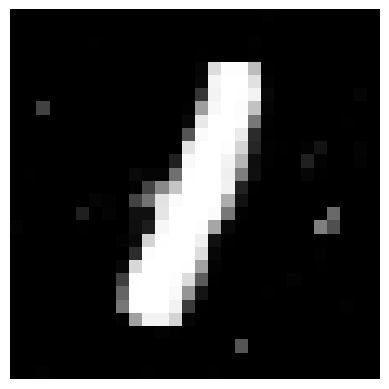

In [12]:
import matplotlib.pyplot as plt
import torch

generator.eval()

z=torch.randn(1, latent_dim, device=device)

with torch.no_grad():
    generated_img=generator(z).cpu().squeeze()  # Move to CPU and remove extra dimensions

plt.imshow(generated_img, cmap="gray")
plt.axis("off")
plt.show()


In [13]:
# Save generator and discriminator
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("Models saved successfully!")


Models saved successfully!
